## Dataset Download

In [ ]:
#put kaggle.json file in the Files (/content/)
!pip install pyspark
!pip install kaggle
!pip install tqdm
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d yelp-dataset/yelp-dataset 
!unzip yelp-dataset.zip

--2023-05-08 18:52:12--  https://github.com/kabirthakur/Data-Science/blob/main/kaggle.json
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘kaggle.json.1’

kaggle.json.1           [ <=>                ] 143.92K  --.-KB/s    in 0.02s   

2023-05-08 18:52:12 (6.59 MB/s) - ‘kaggle.json.1’ saved [147369]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=f721f8841436ccd64797a9a2180a56a04b8d4d12013a45edb5c4ed3f6c19801c
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in index

## Libraries

In [ ]:
import re
import pyspark
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as f
from pyspark.ml.clustering import KMeans
from pyspark.sql.types import FloatType, DoubleType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.sql.functions import col, count, split, explode, when, lit, sum
from pyspark.sql.functions import array, struct, sort_array, array_min, expr, desc

## Create SparkSession and Import Data

In [ ]:
spark = SparkSession.builder \
    .appName("Yelp") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .getOrCreate()

# businesses dataframe
business_df = spark.read.json("yelp_academic_dataset_business.json")

# users dataframe
user_df = spark.read.json("yelp_academic_dataset_user.json")

# reviews dataframe
review_df = spark.read.json("yelp_academic_dataset_review.json")

In [ ]:
#renaming columns for clarity
business_df = business_df.withColumnRenamed("stars", "business_stars")
review_df = review_df.withColumnRenamed("stars", "review_stars")

## Data cleaning and Feature engineering

Business Dataframe

In [ ]:
restaurants_df = business_df.filter(col("categories").contains("Restaurants"))
restaurants_df = restaurants_df.filter(col("state").contains("PA"))
restaurants_df = restaurants_df.filter(col("is_open").contains("1"))
# Choosing Restaurants in Penssylvania that are open (Based on EDA)

We are only looking at the categories column and will be using most categories as features of out model. The following code takes the categories and pivots them and gives f

In [ ]:
categories_splitted = restaurants_df.select("business_id", split(col("categories"), ", ").alias("categories_array"))
categories_exploded = categories_splitted.select("business_id", explode(col("categories_array")).alias("category"))
distinct_categories = categories_exploded.select("category").distinct().rdd.flatMap(lambda x: x).collect()

for category in tqdm(distinct_categories): 
    categories_exploded = categories_exploded.withColumn(category, when(col("category") == category, 1).otherwise(0))

100%|██████████| 449/449 [02:20<00:00,  3.20it/s]


In [ ]:
new_column_names=categories_exploded.columns
categories_pivoted = categories_exploded.groupBy("business_id").sum()


In [ ]:
columns=categories_pivoted.columns
features=columns[1:]
sums = categories_pivoted.agg(*[f.sum(f.col(c)).alias(c) for c in tqdm(features)]).collect()[0].asDict()
selected_columns = [c for c in sums if sums[c] > 10]

# Including the 'business_id' column in the selected columns
selected_columns.insert(0, columns[0])

result_df = categories_pivoted.select([f.col(c) for c in selected_columns])
result_df=result_df.drop('sum(Restaurants)','sum(Food)') 

100%|██████████| 449/449 [00:01<00:00, 263.65it/s]


In [ ]:
def rename_columns(df):
    """
    Renames columns in a PySpark DataFrame based on the column name in the format 'sum(col)'.
    """
    columns = df.columns
    pattern = re.compile(r'sum\((.*?)\)')

    for column in tqdm(columns):
        match = pattern.search(column)
        if match:
            new_column = match.group(1)
            df = df.withColumnRenamed(column, new_column)

    return df

In [ ]:
business_features = rename_columns(result_df)

100%|██████████| 156/156 [01:23<00:00,  1.86it/s]


In [ ]:
business_features.count(),len(result_df.columns)

(8069, 156)

Users Dataframe

In [ ]:
filtered_reviews_df = review_df.select(f.col('business_id'),f.col('user_id'),)
joined_df = filtered_reviews_df.join(business_features, 'business_id', 'inner')
joined_df = joined_df.drop(f.col("business_id"))
summed_df = joined_df.groupBy("user_id").sum()
user_features=rename_columns(summed_df)

100%|██████████| 156/156 [01:41<00:00,  1.54it/s]


In [ ]:
user_features.count(),len(user_features.columns)

(269462, 156)

### KMeans Analysis

In [ ]:
def kmeans_pipeline(data, input_cols, k_range=(5, 11), seed=42):
    assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
    feature_df = assembler.transform(data)

    inertia_values = []
    silhouette_scores = []
    fig, axs = plt.subplots(1, len(range(*k_range)), figsize=(20, 5))
    fig2, axs2 = plt.subplots(1, len(range(*k_range)), figsize=(20, 5))
    for i,k in enumerate(trange(*k_range)):
        kmeans = KMeans(k=k, featuresCol='features', seed=seed)
        kmeans_model = kmeans.fit(feature_df)
        transformed_df = kmeans_model.transform(feature_df)

        axs[i].hist(transformed_df.select('prediction').rdd.flatMap(lambda x: x).collect(), bins=k)
        axs[i].set_title(f'Cluster Count for k={k}')
        axs[i].set_xlabel('Cluster')
        axs[i].set_ylabel('Count')

        counts = transformed_df.select('prediction').groupBy('prediction').count().orderBy('prediction').rdd.map(lambda x: x[1]).collect()
        log_counts = np.log(counts)

        axs2[i].bar(range(k), log_counts)
        axs2[i].set_title(f'Log Cluster Count for k={k}')
        axs2[i].set_xlabel('Cluster')
        axs2[i].set_ylabel('Log Count')

        evaluator = ClusteringEvaluator()
        silhouette_score = evaluator.evaluate(transformed_df)
        silhouette_scores.append(silhouette_score)

        center_points = kmeans_model.clusterCenters()
        squared_distances = transformed_df.rdd.map(
            lambda x: float(x['features'].squared_distance(center_points[x['prediction']]))
        )
        inertia_values.append(squared_distances.sum())

        # print(f'Finished k={k}')
    plt.tight_layout()    

    return inertia_values, silhouette_scores, fig, fig2

100%|██████████| 6/6 [07:14<00:00, 72.47s/it]


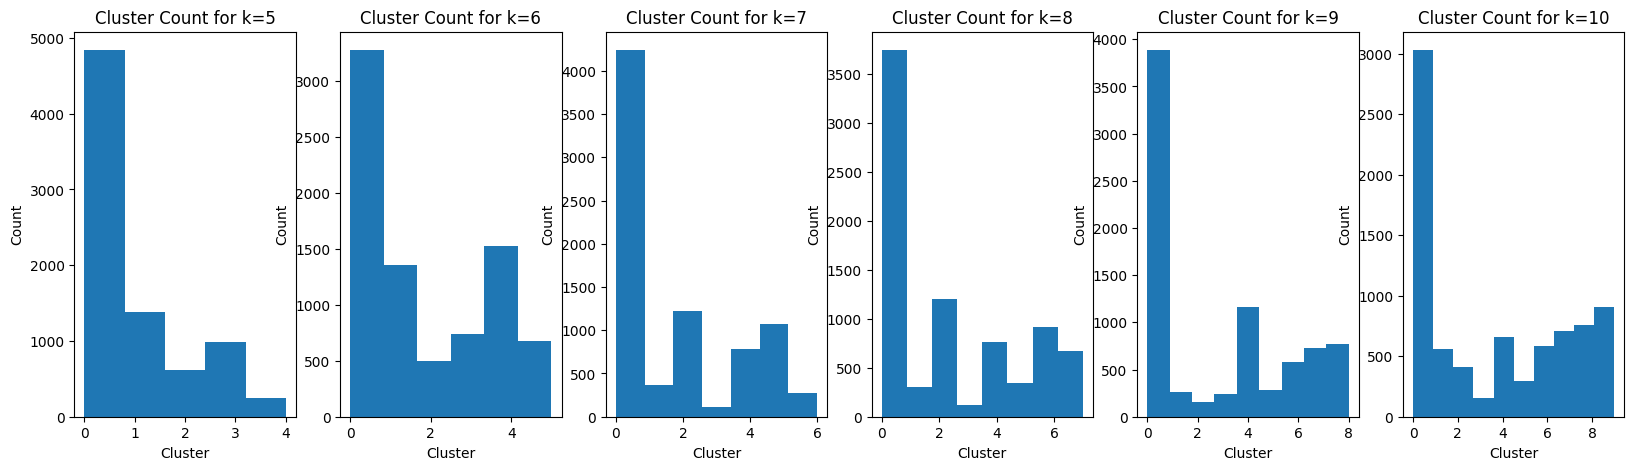

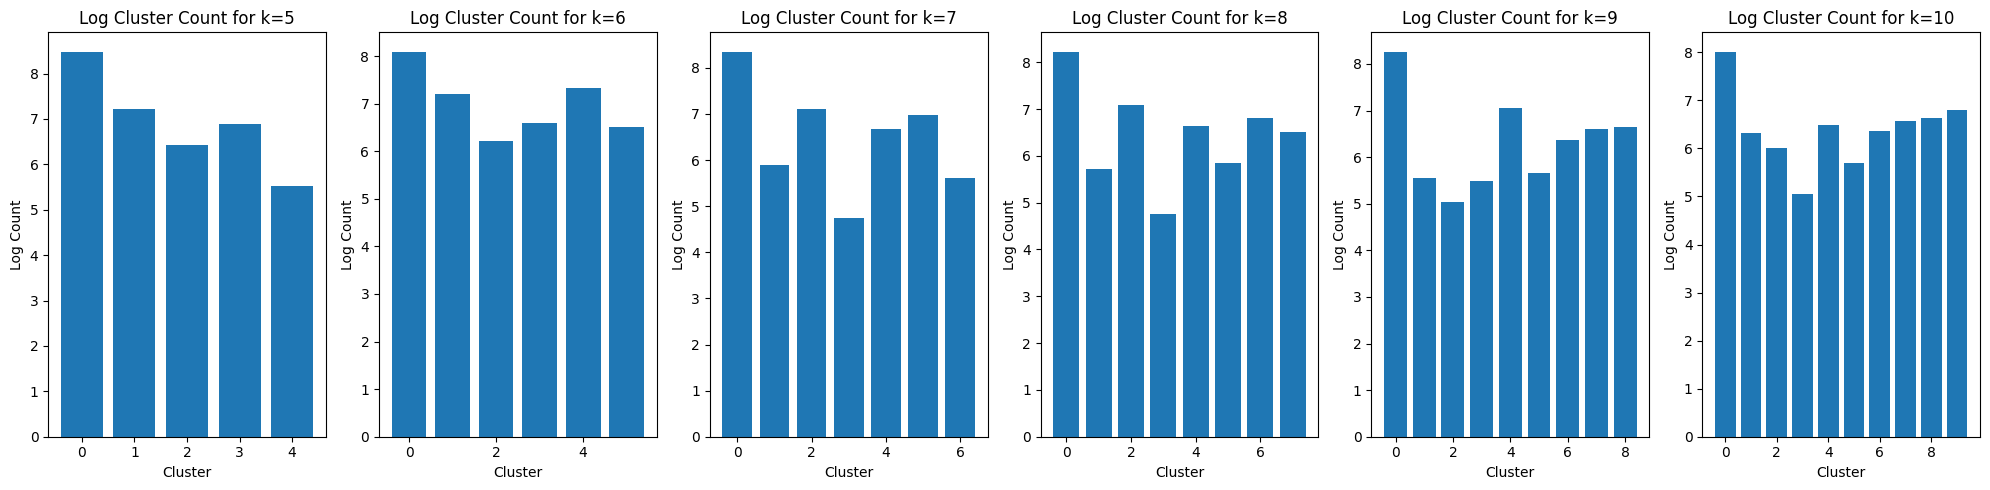

In [ ]:
business_cols = business_features.columns[1:]

# Running the pipeline takes about 10 minutes
inertia_values_business, silhouette_scores_business,fig_plots,fig_logplots = kmeans_pipeline(business_features, business_cols)

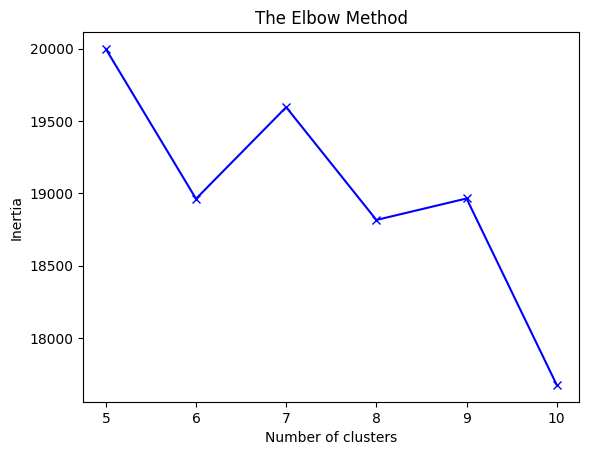

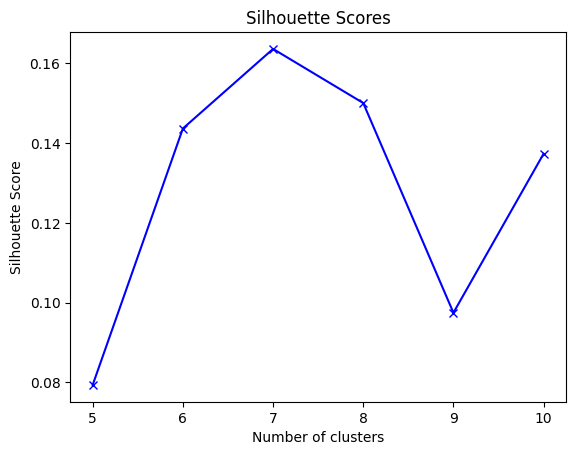

In [ ]:
cluster_range=range(5,11)

plt.plot(cluster_range, inertia_values_business, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

plt.plot(cluster_range, silhouette_scores_business, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()

100%|██████████| 6/6 [1:00:02<00:00, 600.44s/it]


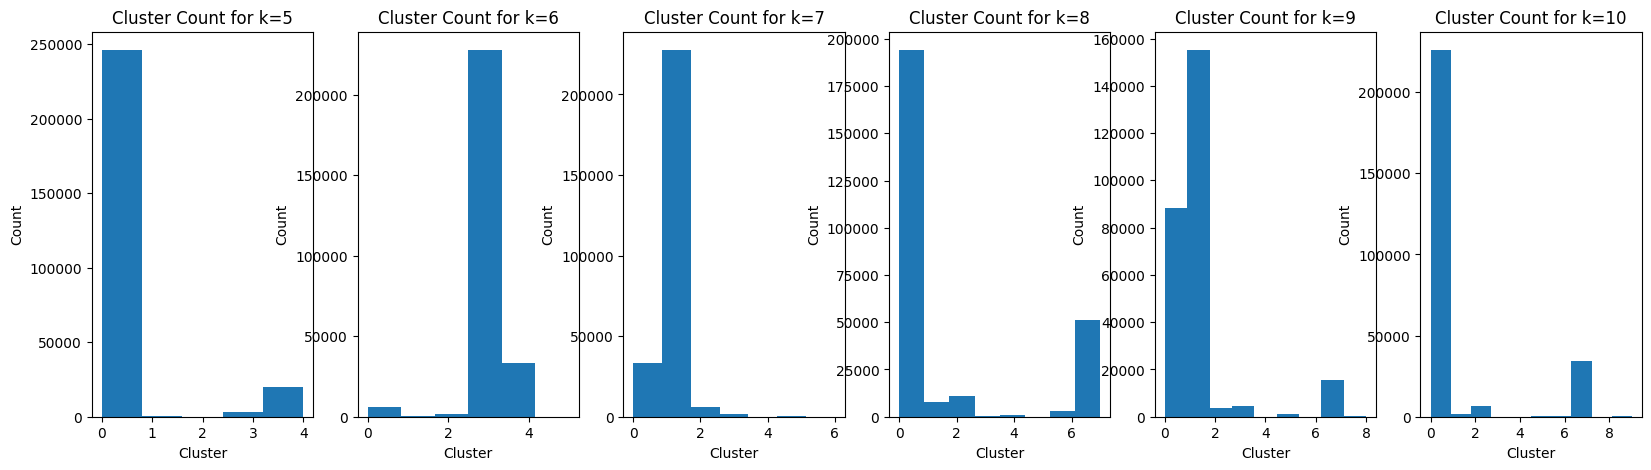

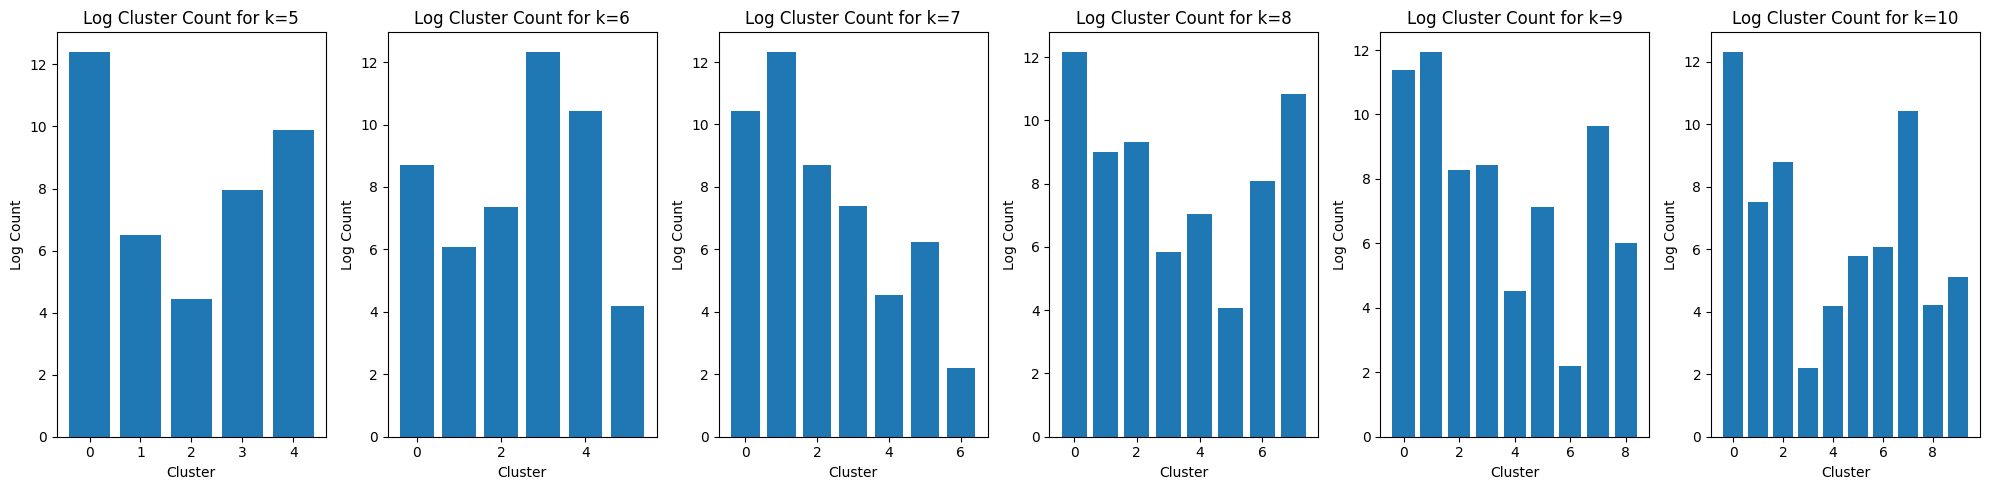

In [ ]:
user_cols = user_features.columns[1:]

# Run the pipeline takes about 1 hr 20 minutes. Got to have patience 
inertia_values_user, silhouette_scores_user, fig_plots_user, fig_logplots_user = kmeans_pipeline(user_features, user_cols)

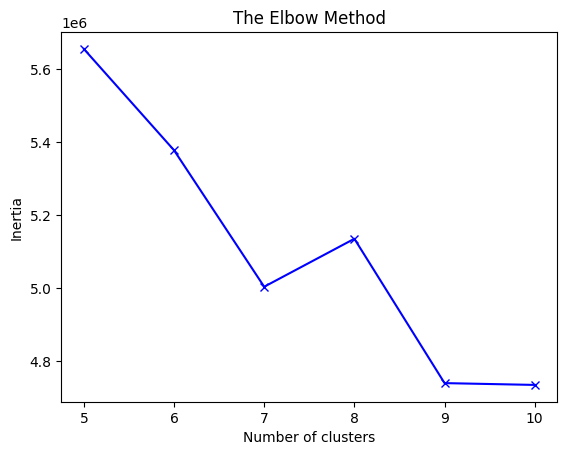

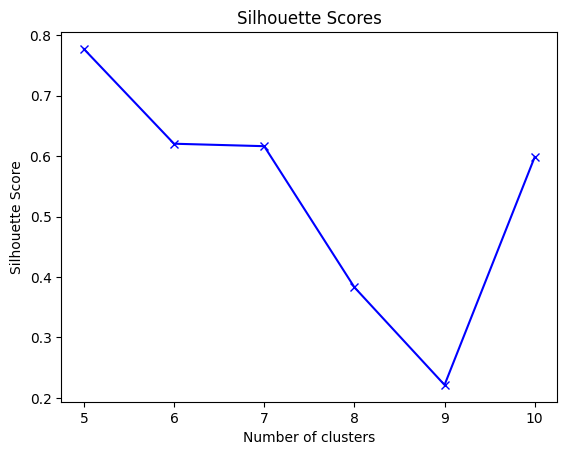

In [ ]:
plt.plot(cluster_range, inertia_values_user, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()
plt.plot(cluster_range, silhouette_scores_user, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')
plt.show()

### K-Means Final Models

### Final Model For Businesses

In [ ]:
assembler = VectorAssembler(inputCols=business_cols, outputCol='features')

kmeans = KMeans(k=6, featuresCol='features', seed=42)

pipeline = Pipeline(stages=[assembler, kmeans])

model_business = pipeline.fit(business_features)

kmeans_business = model_business.stages[-1]

business_centroids = kmeans_business.clusterCenters()

predictions_business = model_business.transform(business_features)


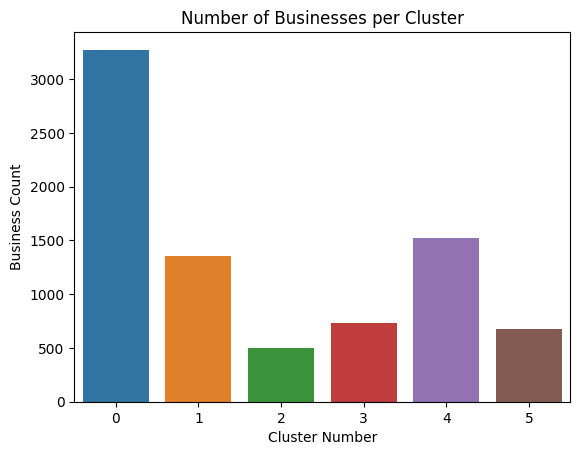

In [ ]:
cluster_counts_business = predictions_business.groupBy("prediction").agg(count("business_id").alias("business_count"))
sns.barplot(x="prediction", y="business_count", data=cluster_counts_business.toPandas())
plt.title("Number of Businesses per Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Business Count")
plt.show()

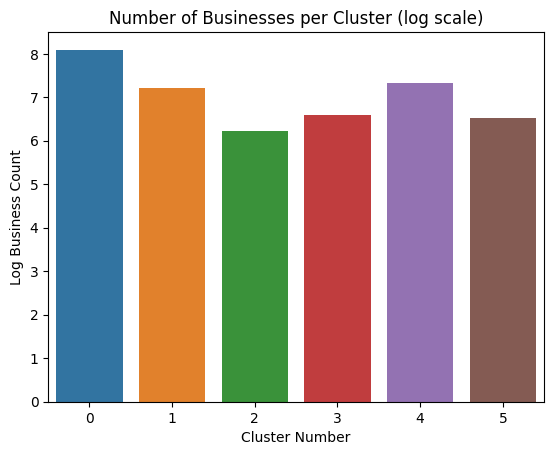

In [ ]:
cluster_counts_business = predictions_business.groupBy("prediction").agg(count("business_id").alias("business_count"))
data_business = cluster_counts_business.toPandas()
sns.barplot(x="prediction", y=np.log(data_business["business_count"]), data=data_business)
plt.title("Number of Businesses per Cluster (log scale)")
plt.xlabel("Cluster Number")
plt.ylabel("Log Business Count")
plt.show()

In [ ]:
# Group by 'prediction' column and count the number of elements in each group
cluster_counts_businesses = predictions_business.groupBy("prediction").count()

# Sort the result by the 'prediction' column and display the counts
cluster_counts_businesses.sort("prediction").show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 3274|
|         1| 1354|
|         2|  502|
|         3|  736|
|         4| 1525|
|         5|  678|
+----------+-----+



### Final Model for Users

In [ ]:
assembler = VectorAssembler(inputCols=user_cols, outputCol='features')

kmeans = kmeans = KMeans(k=6, featuresCol='features', seed=42)

pipeline = Pipeline(stages=[assembler, kmeans])

model_user = pipeline.fit(user_features)

kmeans_user = model_business.stages[-1]

user_centroids = kmeans_user.clusterCenters()

predictions_user = model_user.transform(user_features)


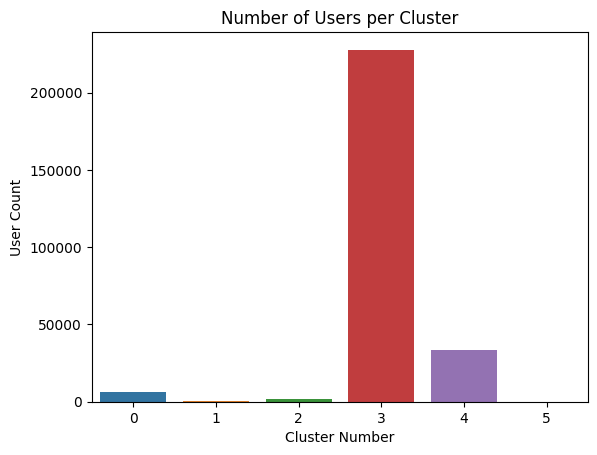

In [ ]:
cluster_counts_user = predictions_user.groupBy("prediction").agg(count("user_id").alias("user_count"))
sns.barplot(x="prediction", y="user_count", data=cluster_counts_user.toPandas())
plt.title("Number of Users per Cluster")
plt.xlabel("Cluster Number")
plt.ylabel("User Count")
plt.show()

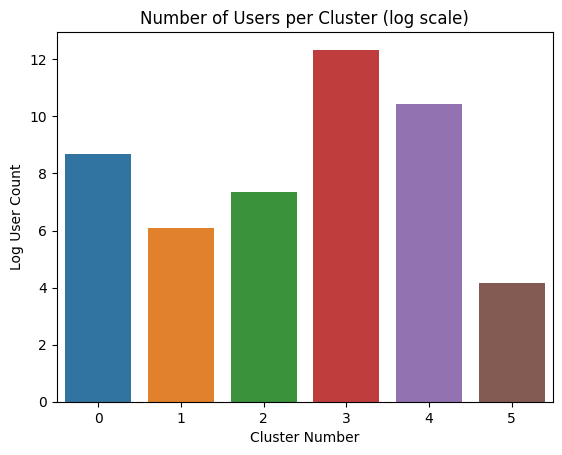

In [ ]:
cluster_counts_user = predictions_user.groupBy("prediction").agg(count("user_id").alias("user_count"))
data_user=cluster_counts_user.toPandas()
sns.barplot(x="prediction", y=np.log(data_user["user_count"]),data=data_user)
plt.title("Number of Users per Cluster (log scale)")
plt.xlabel("Cluster Number")
plt.ylabel("Log User Count")
plt.show()

In [ ]:
# Group by 'prediction' column and count the number of elements in each group
cluster_counts_users = predictions_user.groupBy("prediction").count()

# Sort the result by the 'prediction' column and display the counts
cluster_counts_users.sort("prediction").show()

+----------+------+
|prediction| count|
+----------+------+
|         0|  5992|
|         1|   441|
|         2|  1583|
|         3|227874|
|         4| 33507|
|         5|    65|
+----------+------+



### Dataframe for similar businesses by euclidean distance from centroid

In [ ]:
def split_clusters(dataframe, cluster_column):
    """
    Splits a DataFrame into separate DataFrames based on unique values in the specified column.
    """
    
    unique_clusters = dataframe.select(cluster_column).distinct().collect()
    unique_clusters = [row[cluster_column] for row in unique_clusters]
    cluster_dataframes = {}

    for cluster in unique_clusters:
        cluster_df = dataframe.filter(col(cluster_column) == cluster)
        cluster_dataframes[f"cluster_{cluster}"] = cluster_df

    return cluster_dataframes

In [ ]:
def sort_clusters_by_distance(cluster_dataframes, cluster_centroids):
    """
    Sorts each PySpark DataFrame in the given dictionary of cluster DataFrames
    by the Euclidean distance between each data point and the centroid of its cluster.
    """
    
    def euclidean_distance(vector, array):
        return float(np.linalg.norm(np.array(vector) - np.array(array)))

    euclidean_distance_udf = f.udf(euclidean_distance, DoubleType())
    cluster_label=0
    
    for cluster_name, cluster_df in tqdm(cluster_dataframes.items()):
        cluster_df = cluster_df.withColumn(
            "distance_to_centroid",
            euclidean_distance_udf(f.col("features"), f.array([f.lit(c) for c in cluster_centroids[cluster_label]]))
        )

        # Sort the DF by the Euclidean distance
        cluster_df = cluster_df.sort("distance_to_centroid", ascending=True)

        cluster_dataframes[cluster_name] = cluster_df
        cluster_label+=1 
    return cluster_dataframes


In [ ]:
def recommendations(dfs):
    dfs_pd = {}
    if dfs['cluster_0'].columns[0]=="business_id":
        col_name='business_id'
    else:
        col_name='user_id'
    for cluster, df in tqdm(dfs.items()):
        df_pd = df.toPandas()
        df_pd=df_pd.sort_values('distance_to_centroid')
        df_pd["recommendations"] = None
        for i in range(len(df_pd)):
            if i == 0:
                df_pd.at[i, "recommendations"] = [df_pd.loc[1, col_name], df_pd.loc[2, col_name]]
            elif i == 1:
                df_pd.at[i, "recommendations"] = [df_pd.loc[0, col_name], df_pd.loc[2, col_name]]
            elif i == len(df_pd) - 1:
                df_pd.at[i, "recommendations"] = [df_pd.loc[i-1, col_name], df_pd.loc[i-2, col_name]]
            elif i == len(df_pd) - 2:
                df_pd.at[i, "recommendations"] = [df_pd.loc[i+1, col_name], df_pd.loc[i-1, col_name]]
            else:
                df_pd.at[i, "recommendations"] = [df_pd.loc[i-1, col_name], df_pd.loc[i+1, col_name]]

        df_spark = spark.createDataFrame(df_pd)
        dfs_pd[cluster] = df_spark
    return dfs_pd

In [ ]:
def merge_cluster_dataframes(dic):
    merged = []
    for i in range(len(dic)):
        businesses = dic[f"cluster_{i}"].withColumn("Cluster", lit(i))
        merged.append(businesses)
        
    elements_all = merged[0]
    for i in range(1, len(merged)):
        elements_all = elements_all.union(merged[i])

    return elements_all

1. predictions_business is the transformed model dataframe. I split the data by the clusters to make the computation easier. 
2. The split_clusters function splits the clusters into a dictionary where the key is the cluster and the value is the dataframe object of each cluster. This is the object that we will be using thoughout. The split cluster function is genralised and works for both user and business data with the prediction column.


In [ ]:
business_rec=predictions_business.select("business_id",'features','prediction')
dict_businesses = split_clusters(business_rec, "prediction")
user_rec=predictions_user.select("user_id",'features','prediction')
dict_user = split_clusters(user_rec, "prediction")

3.  The sort_clusters_by_distance function takes in the dictionary we created and the array of centroids from the k-means model and calculated euclidean distance from centroid to each point. The dataframe is then sorted by distance.

NOTE : A lot of points are on similar distances 

In [ ]:
dict_businesses=sort_clusters_by_distance(dict_businesses,business_centroids)
dict_user=sort_clusters_by_distance(dict_user,user_centroids)

100%|██████████| 6/6 [00:22<00:00,  3.77s/it]


4. The recommendations function takes the dictionary and transforms each dataframe to a pandas object. This is done to iterate over the data as we wanted to assign recommendations based on how far each user is from the centroid based on distance. This function ensures that the data is sorted by distance and then assigns two recommendations to each id, specifically the one above it and the one below it in the progression. Same dictionary is returned with a recommendation column.

In [ ]:
dict_businesses=recommendations(dict_businesses)
dict_user=recommendations(dict_user)

100%|██████████| 6/6 [17:11<00:00, 171.94s/it]


5. Finally the dictionary is merged together 

In [ ]:
business_recommendations=merge_cluster_dataframes(dict_businesses)
user_recommendations=merge_cluster_dataframes(dict_user)

Business recommendation dataframe contains the names of two similar businesses as recommendations for each unique business

In [ ]:
business_recommendations.select('business_id','recommendations').show(truncate=False) # Here the recommendations are other businesses

+----------------------+------------------------------------------------+
|business_id           |recommendations                                 |
+----------------------+------------------------------------------------+
|ziFtaIQdzQfFL79iLTq_zQ|[_snyGj46oghIWXSDcrxq1A, zNi8ceY3sLBXZoTUstjrvg]|
|_snyGj46oghIWXSDcrxq1A|[ziFtaIQdzQfFL79iLTq_zQ, zNi8ceY3sLBXZoTUstjrvg]|
|zNi8ceY3sLBXZoTUstjrvg|[_snyGj46oghIWXSDcrxq1A, zWQWjJ0270yqp_KignAmkg]|
|zWQWjJ0270yqp_KignAmkg|[zNi8ceY3sLBXZoTUstjrvg, jREUbQSPxCd3lS0AouzTzg]|
|jREUbQSPxCd3lS0AouzTzg|[zWQWjJ0270yqp_KignAmkg, 6zXBmEBGqFVwTcPqmGStfw]|
|6zXBmEBGqFVwTcPqmGStfw|[jREUbQSPxCd3lS0AouzTzg, kmKHBCTec-e6H4aK7fD8Ag]|
|kmKHBCTec-e6H4aK7fD8Ag|[6zXBmEBGqFVwTcPqmGStfw, Sk1WdGuaCNQlQZ_u_JE0Ew]|
|Sk1WdGuaCNQlQZ_u_JE0Ew|[kmKHBCTec-e6H4aK7fD8Ag, NxB8M1wnJQ5xoXDiUgqmIg]|
|NxB8M1wnJQ5xoXDiUgqmIg|[Sk1WdGuaCNQlQZ_u_JE0Ew, OAs42PSxiaPS25sO8Vtfiw]|
|YinVjl_e8croGmeUK8hRkA|[egFo1PkGkKM-lPli61raiA, Rx6d8NSWTdOt9Nd8QWjfZw]|
|Rx6d8NSWTdOt9Nd8QWjfZw|[YinVjl_e8croG

User recommendation dataframe contains the names of two similar users as recommendations for each unique user. While getting the recommendation from user cluster we use the top rated businesses visited by the similar user.

In [ ]:
user_recommendations.select('user_id','recommendations').show(truncate=False) #Here the recommendations are other users

+----------------------+------------------------------------------------+
|user_id               |recommendations                                 |
+----------------------+------------------------------------------------+
|pRAG05KXr_mZY0gzKAwAPw|[75--7VO10mTfrvV3yCGuHg, huayr-WjhExgJPIZcRhZIQ]|
|75--7VO10mTfrvV3yCGuHg|[pRAG05KXr_mZY0gzKAwAPw, huayr-WjhExgJPIZcRhZIQ]|
|huayr-WjhExgJPIZcRhZIQ|[75--7VO10mTfrvV3yCGuHg, NmC36b6gUGg-kcvm7BiqHg]|
|NmC36b6gUGg-kcvm7BiqHg|[huayr-WjhExgJPIZcRhZIQ, H9x_8vghL3a7Gp6OckLhZQ]|
|H9x_8vghL3a7Gp6OckLhZQ|[NmC36b6gUGg-kcvm7BiqHg, -_x2LGJj_YKxJcM-P2Kvkg]|
|-_x2LGJj_YKxJcM-P2Kvkg|[H9x_8vghL3a7Gp6OckLhZQ, YDjpFw_K46BW9Wf9c8izzA]|
|YDjpFw_K46BW9Wf9c8izzA|[-_x2LGJj_YKxJcM-P2Kvkg, C9xi-33ob-hlRXF7uuIuCQ]|
|C9xi-33ob-hlRXF7uuIuCQ|[YDjpFw_K46BW9Wf9c8izzA, iJpgy47yC8tpwy7_6G3tpA]|
|iJpgy47yC8tpwy7_6G3tpA|[C9xi-33ob-hlRXF7uuIuCQ, XhGCAPGI_GEzeV7v-s9RBQ]|
|XhGCAPGI_GEzeV7v-s9RBQ|[iJpgy47yC8tpwy7_6G3tpA, CgNkIOILQowcP3mQaVpX7Q]|
|CgNkIOILQowcP3mQaVpX7Q|[XhGCAPGI_GEze

6. A visit score is calculated for all restaurants. For each person we calculated an avg score that they gave to the restaurants they visited and that is in the visit_score dataframe. This is done by joining the restaurant table to the review table.

In [ ]:
from pyspark.sql.functions import avg
b_mod = business_df.filter(col("categories").contains("Restaurants"))
b_mod = restaurants_df.filter(col("state").contains("PA"))
b_mod = restaurants_df.filter(col("is_open").contains("1"))
visit_score = review_df.groupBy('user_id', 'business_id').agg(avg('review_stars').alias('avg_review_stars'))
visit_score = b_mod.join(visit_score, on="business_id", how="inner")
visit_score=visit_score.select('business_id','user_id','avg_review_stars')

7. This information about each restaurant and the respective avg rating given to them by the user is added to the row for each user_id. This is saved in visits_df 

In [ ]:
from pyspark.sql.functions import collect_list, struct, desc, sort_array

# assuming your dataframe is called 'new_df'
user_business_df = visit_score.select('user_id', struct('business_id', 'avg_review_stars').alias('business_review'))
grouped_df = user_business_df.groupBy('user_id').agg(collect_list('business_review').alias('businesses'))
visits_df = grouped_df.select('user_id', sort_array('businesses', asc=False).alias('businesses'))

# Recommendation Engine

1. Get recommendations from business clustering model

In [ ]:
def business_cluster_rec(user_id, visits_df, business_recommendations):
    # Find the top 3 businesses for each user
    top_3_businesses = visits_df.filter(col("user_id") == user_id) \
                                 .select(col("user_id"), explode(col("businesses")).alias("businesses"))
    expanded_df = top_3_businesses \
        .withColumn("business_id", col("businesses.business_id")) \
        .withColumn("score", col("businesses.avg_review_stars")) \
        .drop("businesses")
    expanded_df.filter(col("score") >= 3)
    
    result_df = expanded_df.join(business_recommendations, on="business_id", how="inner") \
                           .select("user_id", "business_id", "score", "recommendations")
    result_df=result_df.select("user_id",'recommendations')
    combined_df = result_df.select('user_id', explode(col('recommendations')).alias('recommendations'))
    
    return combined_df

2. Get recommendations from user clustering model

In [ ]:
def user_cluster_rec(user_id, visits_df, user_recommendations, business_recommendations):
    similar_users=user_recommendations.filter(col("user_id") == user_id) \
                                 .select(col("user_id"), explode(col("recommendations")).alias("recommendations"))
    recommendations_list = similar_users.select("recommendations").rdd.flatMap(lambda x: x).collect()
    results = []
    for recommendation in recommendations_list:
        result_df = business_cluster_rec(recommendation, visits_df, business_recommendations)
        results.append(result_df)
    combined_df = results[0]
    for i in range(1, len(results)):
        combined_df = combined_df.union(results[i])
    combined_df = combined_df.drop('user_id')
    combined_df = combined_df.withColumn('user_id', lit(user_id))
    #combined_df = combined_df.select('user_id', explode(col('recommendations')).alias('recommendations'))
    combined_df=combined_df.select('user_id', 'recommendations')
    return combined_df

3. Merge recommendations and fetch names

In [ ]:
def merge_recommendations(u_cluster_recs, b_cluster_recs, user_df, business_df):
    u_cluster_recs = u_cluster_recs.withColumn("cluster_type", lit("u"))

    b_cluster_recs = b_cluster_recs.withColumn("cluster_type", lit("b"))
    
    combined_recs = u_cluster_recs.union(b_cluster_recs)

    combined_recs = combined_recs.join(user_df, on="user_id", how="inner") \
                             .select("user_id", "name", "recommendations",'cluster_type') \
                             .withColumnRenamed("name", "name_user")
    combined_recs = combined_recs.join(business_df, col("recommendations") == col("business_id"), "inner") \
                             .select("user_id", "name_user", "recommendations", "name",'cluster_type') \
                             .withColumnRenamed("name", "name_restaurant")
    combined_recs = combined_recs.select('name_user',"name_restaurant",'cluster_type')
    return combined_recs

### Recommendations for User Desirae

In [ ]:
user_id='6O4seIFz_buDGYXCOIT03A'
b_cluster_recs=business_cluster_rec(user_id,visits_df, business_recommendations)
u_cluster_recs=user_cluster_rec(user_id, visits_df, user_recommendations, business_recommendations)
final=merge_recommendations(u_cluster_recs, b_cluster_recs, user_df, business_df)
final.show(truncate=False)

+---------+-----------------------+------------+
|name_user|name_restaurant        |cluster_type|
+---------+-----------------------+------------+
|Desirae  |Charley's Grilled Subs |u           |
|Desirae  |FreshWorks of Levittown|u           |
|Desirae  |Walt's Steak Shop      |u           |
|Desirae  |Charley's Grilled Subs |u           |
|Desirae  |FreshWorks of Levittown|b           |
|Desirae  |La Casa Del Sandwich   |b           |
+---------+-----------------------+------------+



Restaurants previously visited by Desirae

In [ ]:
business_ids = review_df.filter(col("user_id") == "6O4seIFz_buDGYXCOIT03A") \
                         .select("business_id") \
                         .distinct()
business_names = business_ids.join(business_df, on="business_id", how="inner") \
                             .select(col("business_id"), col("name"))

business_names.select('name').show()

+--------------------+
|                name|
+--------------------+
|Cosmos Fine Nail ...|
|          Jeans Cafe|
+--------------------+



Cluster number for Desirae

In [ ]:
#Desirae
filtered_df = predictions_user.filter(col('user_id') == '6O4seIFz_buDGYXCOIT03A')

prediction_value = filtered_df.select('prediction').collect()[0][0]

print(prediction_value)

3


### Recommendations for User Aaron

In [ ]:
user_id='A3DrdXmkNb1I6x-lSbj96g'
b_cluster_recs=business_cluster_rec(user_id,visits_df, business_recommendations)
u_cluster_recs=user_cluster_rec(user_id, visits_df, user_recommendations, business_recommendations)
final=merge_recommendations(u_cluster_recs, b_cluster_recs, user_df, business_df)
final.show(truncate=False)

+---------+--------------------------------+------------+
|name_user|name_restaurant                 |cluster_type|
+---------+--------------------------------+------------+
|Aaron    |Tony Luke's                     |u           |
|Aaron    |Slack's Hoagie Shack            |u           |
|Aaron    |Pompei’s State Street Sandwiches|u           |
|Aaron    |Angelina's Panini Bar           |u           |
|Aaron    |Sam's Sub Shop                  |b           |
|Aaron    |Angelina's Panini Bar           |b           |
+---------+--------------------------------+------------+



Restaurants previously visited by Aaron


In [ ]:
business_ids = review_df.filter(col("user_id") == "A3DrdXmkNb1I6x-lSbj96g") \
                         .select("business_id") \
                         .distinct()
business_names = business_ids.join(business_df, on="business_id", how="inner") \
                             .select(col("business_id"), col("name"))

business_names.select('name').show(truncate=False)

+--------------------------------+
|name                            |
+--------------------------------+
|Pompei’s State Street Sandwiches|
+--------------------------------+



Cluster number for Aaron

In [ ]:
filtered_df = predictions_user.filter(col('user_id') == 'A3DrdXmkNb1I6x-lSbj96g')

prediction_value = filtered_df.select('prediction').collect()[0][0]

print(prediction_value)

3


This user has visited over 1000 restaurants

In [ ]:
user_id='pou3BbKsIozfH50rxmnMew'
b_cluster_recs=business_cluster_rec(user_id,visits_df, business_recommendations)
u_cluster_recs=user_cluster_rec(user_id, visits_df, user_recommendations, business_recommendations)
final=merge_recommendations(u_cluster_recs, b_cluster_recs, user_df, business_df)
final.show(32,truncate=False)

+---------+-------------------------+------------+
|name_user|name_restaurant          |cluster_type|
+---------+-------------------------+------------+
|Brett    |QDOBA Mexican Eats       |u           |
|Brett    |QDOBA Mexican Eats       |u           |
|Brett    |Biryani City             |u           |
|Brett    |Miss Winnie's            |u           |
|Brett    |Rio Brazilan Steak Truck |u           |
|Brett    |Meat Wagon BBQ           |u           |
|Brett    |Concerto Fusion          |u           |
|Brett    |Tran's Chinese Food Cart |u           |
|Brett    |Sake Hana                |u           |
|Brett    |Kapow Kitchen            |u           |
|Brett    |Rebel Taco               |u           |
|Brett    |Buena Onda               |u           |
|Brett    |Bibou                    |u           |
|Brett    |Landolfi's Cafe & Deli   |u           |
|Brett    |Ummi Dee's burger bistro |u           |
|Brett    |WIBS                     |u           |
|Brett    |Delorenzo's Tomato P

In [ ]:
business_ids = review_df.filter(col("user_id") == "pou3BbKsIozfH50rxmnMew") \
                         .select("business_id") \
                         .distinct()
business_names = business_ids.join(business_df, on="business_id", how="inner") \
                             .select(col("business_id"), col("name"))

business_names.select('name').show(truncate=False)

+----------------------------------------+
|name                                    |
+----------------------------------------+
|The Independent                         |
|Monstah Lobstah                         |
|Endodontic Specialists                  |
|CC's Coffee House                       |
|Brady's BBQ                             |
|Tire Choice Auto Service Centers        |
|Zeko's Mediterranean Grill              |
|Los Comparres                           |
|Tryst Gastro Lounge                     |
|Reservations Bistro                     |
|Quality Foods Market                    |
|Brew D Licious                          |
|Ledo Pizza                              |
|Zoes Kitchen                            |
|Simply Delicious - Country Market & Deli|
|Mazzaro's Italian Market                |
|Icesmile                                |
|Glazer Children's Museum                |
|Angry Chair Brewing                     |
|Bandit Coffee Co.                       |
+----------

In [ ]:
col1 = business_names.select('name')
col2 = final.select("name_restaurant")
intersection = col1.intersect(col2)

intersection.show()

+-----------+
|       name|
+-----------+
|Kung Fu Tea|
|Shake Shack|
+-----------+



In [ ]:
filtered_df = predictions_user.filter(col('user_id') == 'pou3BbKsIozfH50rxmnMew')

prediction_value = filtered_df.select('prediction').collect()[0][0]

print(prediction_value)

4


Business cluster features

In [ ]:
def get_cluster_features(a, predictions_business): 
    
    joined_df = a.join(predictions_business, on=['business_id'], how='inner')

    selected_df = joined_df.select(predictions_business.columns).drop('features','prediction')
    sums_df = selected_df.agg(*[sum(f.col(c)).alias(c) for c in selected_df.columns])

    sorted_sums_df = sums_df.select('*').orderBy(desc(sums_df.columns[0])).drop("business_id")

    b = sorted_sums_df.toPandas()
    cols = b.columns
    list_2 = b.iloc[0].tolist()
    
    data = {'Feature names': cols, 'frequency': list_2}
    df = pd.DataFrame(data)

    df = df.sort_values('frequency', ascending=False)

    return df


In [ ]:
cluster_0=dict_businesses['cluster_0'].drop('features','prediction')
cluster_0_features = get_cluster_features(cluster_0, predictions_business)
cluster_0_features.head(20)

,Feature names,frequency
28,Chinese,595
59,Japanese,295
7,Mexican,281
123,Seafood,279
138,American (New,233
139,Asian Fusion,230
93,Sushi Bars,229
119,American (Traditional,226
65,Event Planning & Services,206
145,Specialty Food,201


In [ ]:
cluster_1=dict_businesses['cluster_1'].drop('features','prediction')
cluster_1_features = get_cluster_features(cluster_1, predictions_business)
cluster_1_features.head(20)

,Feature names,frequency
74,Pizza,1354
84,Italian,474
97,Sandwiches,324
75,Chicken Wings,122
61,Cheesesteaks,118
2,Salad,107
119,American (Traditional,94
73,Burgers,81
65,Event Planning & Services,72
98,Caterers,64


In [ ]:
cluster_2=dict_businesses['cluster_2'].drop('features','prediction')
cluster_2_features = get_cluster_features(cluster_2, predictions_business)
cluster_2_features.head(20)

,Feature names,frequency
48,Nightlife,502
119,American (Traditional,502
143,Bars,493
15,Sports Bars,156
138,American (New,135
144,Pubs,125
73,Burgers,73
65,Event Planning & Services,66
69,Cocktail Bars,60
123,Seafood,58


In [ ]:
cluster_3=dict_businesses['cluster_3'].drop('features','prediction')
cluster_3_features = get_cluster_features(cluster_3, predictions_business)
cluster_3_features.head(20)

,Feature names,frequency
48,Nightlife,736
143,Bars,724
138,American (New,229
69,Cocktail Bars,142
144,Pubs,128
84,Italian,110
74,Pizza,89
30,Wine Bars,85
123,Seafood,82
3,Beer Bar,82


In [ ]:
cluster_4=dict_businesses['cluster_4'].drop('features','prediction')
cluster_4_features = get_cluster_features(cluster_4, predictions_business)
cluster_4_features.head(20)

,Feature names,frequency
97,Sandwiches,967
55,Breakfast & Brunch,736
80,Coffee & Tea,499
136,Delis,278
95,Cafes,259
119,American (Traditional,254
138,American (New,177
2,Salad,174
50,Convenience Stores,157
12,Bakeries,142


In [ ]:
cluster_5=dict_businesses['cluster_5'].drop('features','prediction')
cluster_5_features = get_cluster_features(cluster_5, predictions_business)
cluster_5_features.head(20)

,Feature names,frequency
68,Fast Food,615
73,Burgers,369
119,American (Traditional,120
80,Coffee & Tea,111
7,Mexican,100
75,Chicken Wings,89
105,Ice Cream & Frozen Yogurt,68
82,Chicken Shop,67
97,Sandwiches,62
65,Event Planning & Services,58


In [ ]:
def top_5_features_bar_graph(df,i):
    df_sorted = df.sort_values(by='frequency', ascending=False)

    top_5_features = df_sorted.head(5)

    ax = top_5_features.plot(x='Feature names', y='frequency', kind='bar', legend=False)

    ax.set_title('Top 5 Features in cluster {}'.format(i))
    ax.set_xlabel('Feature')
    ax.set_ylabel('Frequency')

    return ax.get_figure()

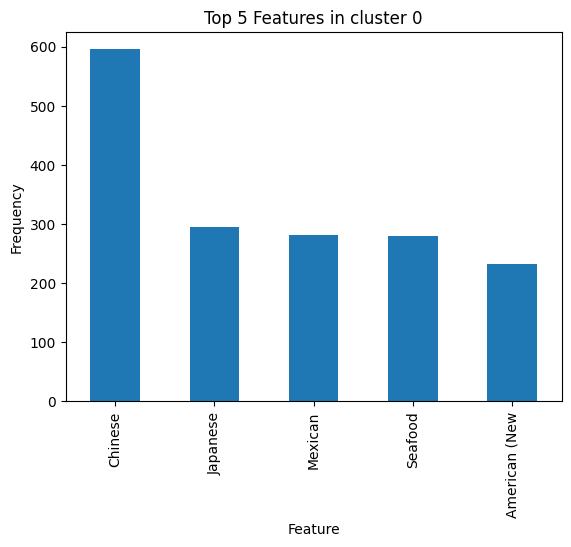

In [ ]:
fig0=top_5_features_bar_graph(cluster_0_features,0)

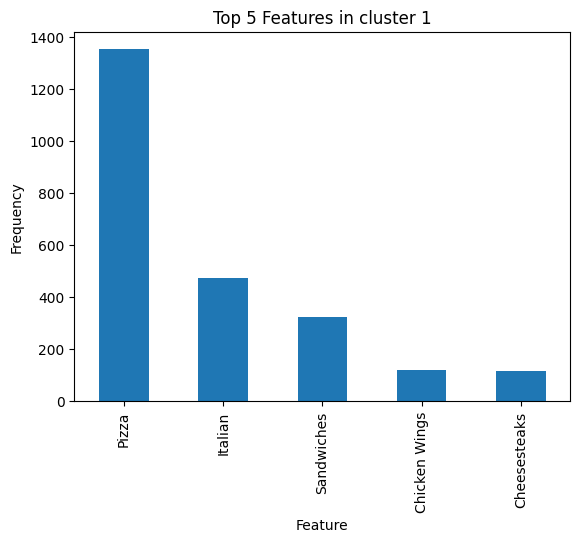

In [ ]:
fig1=top_5_features_bar_graph(cluster_1_features,1)

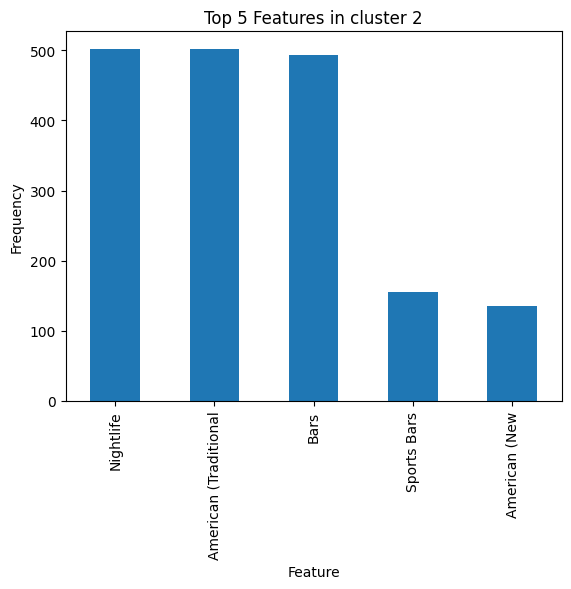

In [ ]:
fig2=top_5_features_bar_graph(cluster_2_features,2)

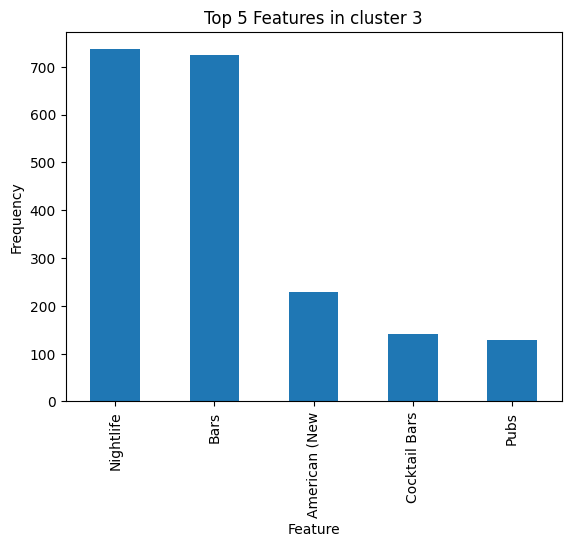

In [ ]:
fig3=top_5_features_bar_graph(cluster_3_features,3)

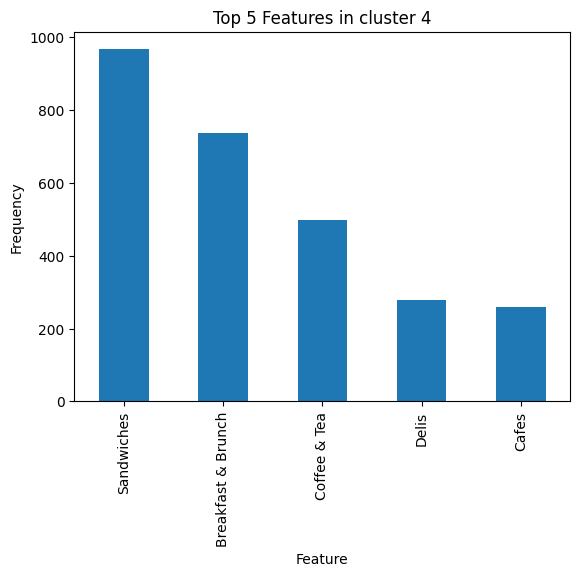

In [ ]:
fig4=top_5_features_bar_graph(cluster_4_features,4)

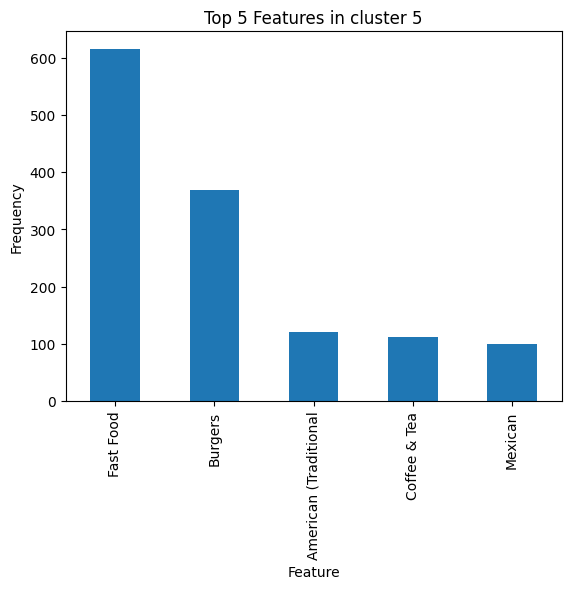

In [ ]:
fig5=top_5_features_bar_graph(cluster_5_features,5)